## **Python for Quantitative Trading: Futures**
### **Integrated CTA Strategies Episode 11 - Strategies with Different Frequencies**

In [1]:
import numpy as np
import pandas as pd
import math
import gzip
import _pickle as cPickle
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime

import os
from helper import *
from stats import *
from product_info import *
import helper
import stats
import dask
from dask import compute, delayed


plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei'] # 用来正常显示中文标签`
plt.rcParams['axes.unicode_minus'] = False

%config InlineBackend.figure_format = 'svg' #在notebook中可以更好的显示，svg输出是一种向量化格式，缩放网页并不会导致图片失真。这行代码似乎只用在ipynb文件中才能使用。

%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')  # 忽略一些warnings

# This allows multiple outputs from a single jupyter notebook cell:
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

pd.set_option('expand_frame_repr', False)  
pd.set_option("display.max_rows", 500) 
pd.set_option('display.max_columns', None) #防止column太多中间变成省略号


c:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
c:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
from imp import reload  
reload(helper)
reload(stats)

<module 'stats' from 'e:\\My_Strategies_CTA\\stats.py'>

In [3]:
HEAD_PATH = r"E:\My_Strategies_CTA" 
DATA_PATH = HEAD_PATH + "\\pkl_tick" 
NIGHT_PATH = HEAD_PATH + "\\night_pkl_tick\\"
SAVE_PATH = r"E:\My_Strategies_CTA"  #保存计算的因子数据的地方
SIGNAL_PATH = r"E:\My_Strategies_CTA" 
CORE_NUM = int(os.environ['NUMBER_OF_PROCESSORS'])
CORE_NUM

16

In [4]:
product_list = ["rb", "hc", "i", "j", "jm"]
product = product_list[0] #随便取一个商品期货，可以更改
print(product)
all_dates = os.listdir(DATA_PATH + "\\" + product)
all_dates.sort()
n_days = len(all_dates)
print(len(all_dates), all_dates[:6])

rb
1063 ['20170103.pkl', '20170104.pkl', '20170105.pkl', '20170106.pkl', '20170109.pkl', '20170110.pkl']


In [5]:
period = 4096

# train and test
train_sample = np.array(all_dates) < "2019"
test_sample = np.array(all_dates) > "2019"

# 记录时间的字符串和时间格式
date_str = [n[0:8] for n in all_dates]
format_dates = np.array([pd.to_datetime(d) for d in date_str])


In [6]:
os.makedirs(HEAD_PATH+"\\all_signals", exist_ok=True)
dire_signal_list = ["trade.imb", "total.trade.imb", "nr", "dbook", "range.pos", "price.osci", "ma.dif.10", "kdj.k", "kdj.j"]
range_signal_list = ["", "range", "std", "volume.open.ratio", "trend.index"]
all_signal_list = np.array([])
for range_signal in range_signal_list:
    for dire_signal in dire_signal_list:
        if len(range_signal)==0:
            signal_name = dire_signal
        else:
            signal_name = dire_signal+"."+range_signal
        all_signal_list = np.append(all_signal_list,signal_name)
n_signal = len(all_signal_list)
signal_list = [signal+".4096" for signal in all_signal_list]

In [7]:
import sklearn.preprocessing
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import lasso_path, LassoCV
from sklearn.preprocessing import StandardScaler
y_signal = "ret."+str(period)+".002"

In [8]:
def get_multiple_sample_signal(good_night_files, sample, product, signal_name, period, daily_num, mod=np.array([0])):
    n_samples = int(sum(daily_num[sample]))
    n_mod = len(mod)
    if n_mod==1:
        all_signal = np.zeros(n_samples)
    else:
        all_signal = np.zeros((n_mod, n_samples))
    cur = 0
    for file in good_night_files[sample]:
        good = load(SAVE_PATH+"\\good_pkl\\"+product+"\\"+file)
        S = load(SAVE_PATH+"\\factor_pkl\\"+product+"\\"+signal_name+"\\"+file)
        S = S[good]
        for i in range(n_mod):
            signal = S[(np.arange(len(S))+1) % period == mod[i]]
            ## the ret.cor has some bad records
            signal[np.isnan(signal)] = 0
            signal[np.isinf(signal)] = 0
            if mod[i]==0: 
                cur_end = np.min((cur+len(signal),n_samples))
            if n_mod==1:
                all_signal[cur:cur_end] = signal[0:(cur_end-cur)]
            else:
                all_signal[i, cur:cur_end] = signal[0:(cur_end-cur)]
        cur = cur_end
    return all_signal

In [9]:
mod = np.arange(0, np.floor(period/10)*10, np.floor(period/10))
n_mod = len(mod)

In [16]:
os.makedirs(SAVE_PATH+"\\train_test_array", exist_ok=True)

In [18]:
%%time
for product in product_list:
    print(product)
    daily_num = load(HEAD_PATH+"\\daily_num\\"+product+".pkl")
    n_train = sum(daily_num[train_sample])
    n_test = sum(daily_num[test_sample])
    train_array = np.zeros((n_mod, int(n_train), n_signal+1))
    for i in range(n_signal):
        train_array[:,:,i] = get_multiple_sample_signal(np.array(all_dates), train_sample, product, signal_list[i], period, daily_num, mod)
    train_array[:,:,n_signal] = get_multiple_sample_signal(np.array(all_dates), train_sample, product, "ret."+str(period), period, daily_num, mod)
    save(train_array, HEAD_PATH+"\\train_test_array\\"+product+".train.array.pkl")

rb
hc
i
j
jm
Wall time: 10min 1s


In [10]:
all_train_array = dict([])
for product in product_list:
    all_train_array[product] = load(HEAD_PATH+"\\train_test_array\\"+product+".train.array.pkl")

In [22]:
nfold = 10
model_coef = dict([])
for product in product_list:
    model_coef[product] = np.zeros(n_signal)
for i_mod in range(n_mod):
    train_std_mat = dict([])
    x_train = np.zeros((0, n_signal))
    y_train = np.array([])
    for product in product_list:
        cur_mat = all_train_array[product][i_mod,:,:]
        train_std_mat[product] = np.std(cur_mat, axis=0)
        x_train = np.vstack((x_train, cur_mat[:,:n_signal]/train_std_mat[product][:n_signal]))
        y_train = np.concatenate((y_train, cur_mat[:,n_signal]/train_std_mat[product][n_signal]))
    scaler =  StandardScaler(copy=True, with_mean=False, with_std=True)
    scaler.fit(x_train)
    x_std = np.sqrt(scaler.var_)
    x_train_normal = scaler.transform(x_train)
    model = LassoCV(n_alphas=100, fit_intercept=False, cv=10, max_iter=10000).fit(x_train_normal, y_train)
    fit_coef = model.coef_/x_std
    for product in product_list:
        coef = fit_coef*train_std_mat[product][n_signal]/train_std_mat[product][:n_signal]
        model_coef[product] = model_coef[product]+coef/n_mod

In [21]:
save(model_coef, SAVE_PATH+"\\processed_data\\black.ensemble.model.pkl")

In [11]:
model_coef = load(SAVE_PATH+"\\processed_data\\black.ensemble.model.pkl")

In [12]:
model_coef

{'rb': array([-1.00130563e-04, -3.97066901e-05,  3.30786188e-05, -1.34861998e-03,
         0.00000000e+00,  2.24150081e-04,  1.82200520e-02,  8.78032768e-05,
         1.00341466e-04,  4.56747597e-07, -7.64902768e-06,  1.80466399e-05,
         9.58768599e-06, -4.99636144e-05,  1.22292464e-06,  2.80698127e-04,
         0.00000000e+00,  0.00000000e+00, -1.71438694e-06,  0.00000000e+00,
         1.30444932e-04,  1.48808229e-05,  0.00000000e+00,  1.09738997e-06,
        -1.79485123e-04,  4.41468311e-06,  9.52208389e-06, -9.17723923e-05,
        -5.80523931e-04,  0.00000000e+00, -1.97578048e-03, -5.40813856e-03,
         1.00884070e-04, -3.71692448e-02,  3.06840016e-04,  0.00000000e+00,
        -1.01004184e-03,  5.51388051e-04,  0.00000000e+00, -1.11473626e-03,
        -2.67168351e-04,  1.48526037e-04,  1.03802318e-02,  4.83125665e-05,
        -4.38273245e-05]),
 'hc': array([-1.17706390e-04, -4.59132011e-05,  4.32856922e-05, -2.19213867e-03,
         0.00000000e+00,  2.10213645e-04,  1.7557

In [24]:
strat = "ensemble.lasso."+str(period)
for product in product_list:
    os.makedirs(SAVE_PATH+"\\factor_pkl\\"+product+"\\"+strat, exist_ok=True)

In [25]:
%%time
for product in product_list:
    print(product)
    coef = model_coef[product]
    parLapply(CORE_NUM, all_dates, par_get_daily_pred, 
              product=product, coef=coef, strat=strat, HEAD_PATH=HEAD_PATH, SAVE_PATH=SAVE_PATH)

rb
hc
i
j
jm
Wall time: 2min 49s


In [26]:
%%time
for product in product_list:
    par_get_all_signal(strat, all_dates, product, 4096, SAVE_PATH=SAVE_PATH)

Wall time: 26.3 s


In [27]:
%%time
for product in product_list:
    spread = product_info[product]["spread"]
    evaluate_signal("ensemble.lasso", np.array(all_dates), product, 2, 20, CORE_NUM, HEAD_PATH, SAVE_PATH,
                    period=4096, split_str="2019", tranct=1.1e-4, 
                    max_spread=spread*1.1, tranct_ratio=False, atr_filter=0.01, save_path="signal_result_atr",reverse=1)

reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
Wall time: 4min 58s


In [28]:
for product in product_list:
    spread = product_info[product]["spread"]
    signal_stat = load(HEAD_PATH+"\\signal_result_atr\\"+product+"."+"ensemble.lasso.4096"+".trend.pkl")
    train_stat = signal_stat["train.stat"]
    good_strat = (train_stat["final.result"]["avg.pnl"]>2*spread)
    train_pnl = train_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    test_stat = signal_stat["test.stat"]
    test_pnl = test_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))

rb train sharpe  0.5881378789107498 test sharpe  0.41762268302494365
hc train sharpe  0.7455817699382021 test sharpe  0.4828342842406056
i train sharpe  1.095944872847482 test sharpe  -0.12612654090027547
j train sharpe  1.130674611614598 test sharpe  1.8127339348870837
jm train sharpe  1.7208890383720503 test sharpe  -0.6296974413987417


In [29]:
nfold = 10
model_coef = dict([])
for i_mod in range(n_mod):
    train_std_mat = dict([])
    model_coef[str(i_mod)] = dict([])
    x_train = np.zeros((0, n_signal))
    y_train = np.array([])
    for product in product_list:
        cur_mat = all_train_array[product][i_mod,:,:]
        train_std_mat[product] = np.std(cur_mat, axis=0)
        x_train = np.vstack((x_train, cur_mat[:,:n_signal]/train_std_mat[product][:n_signal]))
        y_train = np.concatenate((y_train, cur_mat[:,n_signal]/train_std_mat[product][n_signal]))
    scaler =  StandardScaler(copy=True, with_mean=False, with_std=True)
    scaler.fit(x_train)
    x_std = np.sqrt(scaler.var_)
    x_train_normal = scaler.transform(x_train)
    model = LassoCV(n_alphas=100, fit_intercept=False, cv=10, max_iter=10000).fit(x_train_normal, y_train)
    fit_coef = model.coef_/x_std
    for product in product_list:
        coef = fit_coef*train_std_mat[product][n_signal]/train_std_mat[product][:n_signal]
        model_coef[str(i_mod)][product] = coef

In [30]:
save(model_coef, SAVE_PATH+"\\processed_data\\black.ensemble.all.coef.pkl")

In [31]:
%%time
for i_mod in range(n_mod):
    print(i_mod)
    strat = "ensemble.lasso."+str(i_mod)+"."+str(period)
    for product in product_list:
        os.makedirs(SAVE_PATH+"\\factor_pkl\\"+product+"\\"+strat, exist_ok=True)
        coef = model_coef[str(i_mod)][product]
        parLapply(CORE_NUM, all_dates, par_get_daily_pred, 
                  product=product, coef=coef, strat=strat, HEAD_PATH=HEAD_PATH, SAVE_PATH=SAVE_PATH)
        par_get_all_signal(strat, all_dates, product, 4096, SAVE_PATH=SAVE_PATH)    
        spread = product_info[product]["spread"]
        evaluate_signal("ensemble.lasso."+str(i_mod), np.array(all_dates), product, 2, 20, CORE_NUM, HEAD_PATH, SAVE_PATH,
                        period=4096, split_str="2019", tranct=1.1e-4, 
                        max_spread=spread*1.1, tranct_ratio=False, atr_filter=0.01, save_path="signal_result_atr",reverse=1)

0
reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
1
reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
2
reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
3
reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
4
reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
5
reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
6
reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
7
reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
8
reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
9
reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
Wall time: 1h 27min 8s


In [32]:
min_pnl = 2
min_num = 10
all_portfolio = np.zeros((sum(test_sample)+sum(train_sample),n_mod))
for i_mod in range(n_mod):
    strat = "ensemble.lasso."+str(i_mod)+"."+str(period)
    i = 0
    test_all_pnl = np.zeros([sum(test_sample), len(product_list)])
    train_all_pnl = np.zeros([sum(train_sample), len(product_list)])
    for product in product_list:
        spread = product_info[product]["spread"]
        signal_stat = load(HEAD_PATH+"\\signal_result_atr\\"+product+"."+strat+".trend.pkl")
        train_stat = signal_stat["train.stat"]
        good_strat = (train_stat["final.result"]["avg.pnl"]>min_pnl*spread) & (train_stat["final.result"]["num"]>min_num)
        train_pnl = train_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
        test_stat = signal_stat["test.stat"]
        test_pnl = test_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
        print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))
        if sum(good_strat)==0:
            test_pnl = np.zeros(sum(test_sample))
            train_pnl = np.zeros(sum(train_sample))
        test_all_pnl[:,i] = test_pnl
        train_all_pnl[:,i] = train_pnl
        i = i+1
    train_portfolio = np.array(np.mean(train_all_pnl, axis=1))
    test_portfolio = np.array(np.mean(test_all_pnl, axis=1))
    all_portfolio[:,i_mod] = np.append(train_portfolio, test_portfolio)

rb train sharpe  1.0925305656934594 test sharpe  0.315077183458294
hc train sharpe  1.4252591180586232 test sharpe  0.1476200895066984
i train sharpe  0.7949207409107137 test sharpe  0.042715490381475
j train sharpe  1.1600129138971618 test sharpe  0.2916127214667432
jm train sharpe  0.5469583754239747 test sharpe  -1.0925560437047395
rb train sharpe  0.8040008309123385 test sharpe  0.949274215086458
hc train sharpe  0.860351521316492 test sharpe  0.43145949406368284
i train sharpe  1.9409615964980345 test sharpe  -0.7312793459621499
j train sharpe  0.776056652391818 test sharpe  1.9146712034966935
jm train sharpe  1.6655916493235043 test sharpe  -0.27613634396366
rb train sharpe  0.48409384228263624 test sharpe  0.4704659102469149
hc train sharpe  0.8286511320170039 test sharpe  0.015461773013520452
i train sharpe  1.2334078352973918 test sharpe  -0.4706487550604966
j train sharpe  1.13431121292944 test sharpe  2.019132424782098
jm train sharpe  2.1534461701801293 test sharpe  -0.6153

train sharpe:  1.7551333111691503 test sharpe:  0.3909091678306983


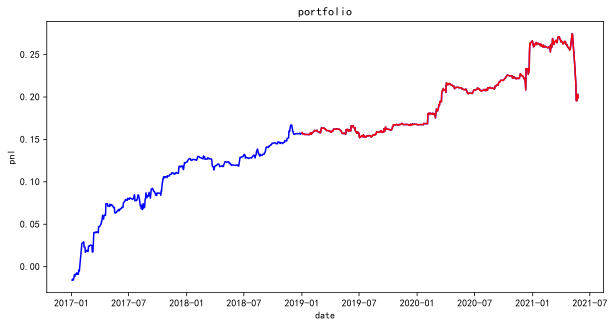

In [33]:
portfolio = np.mean(all_portfolio, axis=1)
train_portfolio = portfolio[train_sample]
test_portfolio = portfolio[test_sample]
plt.figure(1, figsize=(10, 5))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
plt.title("portfolio")
plt.plot(format_dates, portfolio.cumsum(), color="b")
plt.plot(format_dates[test_sample], portfolio.cumsum()[test_sample], color="r")
print("train sharpe: ", sharpe(train_portfolio), "test sharpe: ", sharpe(test_portfolio))

In [13]:
def get_contract(file):
    data = load(file)
    return data["contract"][data["good"]].iloc[0]

In [15]:
contract_list=dict([])
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+"\\" + product+"\\"+x, os.listdir(DATA_PATH + "\\" + product)))
    contract_vec = pd.Series(list(map(get_contract, file_list)))
    print(contract_vec)
    save(contract_vec, HEAD_PATH+"\\processed_data\\"+product+"contract.vec.pkl")
    contract_list[product] = contract_vec

0       rb1705
1       rb1705
2       rb1705
3       rb1705
4       rb1705
         ...  
1058    rb2110
1059    rb2110
1060    rb2110
1061    rb2110
1062    rb2110
Length: 1063, dtype: object
0       hc1705
1       hc1705
2       hc1705
3       hc1705
4       hc1705
         ...  
1058    hc2110
1059    hc2110
1060    hc2110
1061    hc2110
1062    hc2110
Length: 1063, dtype: object
0       i1705
1       i1705
2       i1705
3       i1705
4       i1705
        ...  
1058    i2105
1059    i2109
1060    i2109
1061    i2109
1062    i2109
Length: 1063, dtype: object
0       j1705
1       j1705
2       j1705
3       j1705
4       j1705
        ...  
1058    j2105
1059    j2109
1060    j2109
1061    j2109
1062    j2109
Length: 1063, dtype: object
0       jm1705
1       jm1705
2       jm1705
3       jm1705
4       jm1705
         ...  
1058    jm2105
1059    jm2109
1060    jm2109
1061    jm2109
1062    jm2109
Length: 1063, dtype: object


In [36]:
save(contract_list, HEAD_PATH+"\\processed_data\\contract.list.pkl")

In [16]:
contract_list = load(HEAD_PATH+"\\processed_data\\contract.list.pkl")
product_cum = dict([])
product_len = dict([])
for product in product_list:
    contract_vec = contract_list[product]
    contract_len = contract_vec.value_counts().sort_index()
    contract_cum = contract_len.cumsum()
    product_len[product] = contract_len
    product_cum[product] = contract_cum

In [17]:
product = "rb"
train_sample_list = dict([])
test_sample_list = dict([])
for product in product_list:
    contract_cum = product_cum[product]
    split_date = np.array(all_dates)[contract_cum[np.max(np.where(np.array(all_dates)[contract_cum-1]<"2018"))]]
    medium_train_sample = (np.array(all_dates) < split_date)
    medium_test_sample = (np.array(all_dates) >= split_date)
    train_sample_list[product] = medium_train_sample
    test_sample_list[product] = medium_test_sample

In [18]:
daily_ticks = dict([])
all_mat = dict([])
for product in product_list:
    daily_num = load(HEAD_PATH+"\\daily_num\\"+product+".pkl")
    daily_ticks[product] = daily_num
    test_mat = load(HEAD_PATH+"\\train_test_mat\\"+product+".test.mat.pkl")
    train_mat = load(HEAD_PATH+"\\train_test_mat\\"+product+".train.mat.pkl")
    train_mat
    all_mat[product] = pd.concat((train_mat, test_mat))

In [19]:
train_std = dict([])
all_x_train = dict([])
all_y_train = dict([])
n_sample = 0
for product in product_list:
    medium_train_sample = train_sample_list[product]
    medium_test_sample = test_sample_list[product]
    medium_train_range = range(round(sum((daily_ticks[product][medium_train_sample]))))
    medium_test_range = np.arange(sum(daily_ticks[product][medium_train_sample])+1,sum(daily_ticks[product]))
    medium_train_mat = all_mat[product].iloc[medium_train_range,:]
    medium_test_mat = all_mat[product].iloc[medium_test_range,:]
    x_train = medium_train_mat.iloc[:,:n_signal]
    y_train = medium_train_mat[y_signal]
    train_std[product] = np.std(medium_train_mat)
    all_x_train[product] = x_train
    all_y_train[product] = y_train
    n_sample = n_sample+len(y_train)

In [20]:
x_train = np.zeros((n_sample, n_signal))
y_train = np.zeros(n_sample)
cur = 0
for product in product_list:
    x_train[cur:(cur+len(all_y_train[product])),] = all_x_train[product]/train_std[product][:n_signal]
    y_train[cur:(cur+len(all_y_train[product]))] = all_y_train[product]/train_std[product][y_signal]
    cur = cur+len(all_y_train[product])

In [23]:
coef_list=dict([])
for product in product_list:
    coef = fit_coef*train_std[product][y_signal]/train_std[product][:n_signal]
    coef_list[product] = coef
    print(product)
    print(coef)

rb
trade.imb.4096                           -0.000056
total.trade.imb.4096                     -0.000000
nr.4096                                   0.000000
dbook.4096                               -0.002699
range.pos.4096                           -0.000000
price.osci.4096                           0.000460
ma.dif.10.4096                           -0.000000
kdj.k.4096                                0.000000
kdj.j.4096                                0.000000
trade.imb.range.4096                     -0.000000
total.trade.imb.range.4096               -0.000000
nr.range.4096                             0.000000
dbook.range.4096                          0.000000
range.pos.range.4096                     -0.000084
price.osci.range.4096                    -0.000000
ma.dif.10.range.4096                      0.000000
kdj.k.range.4096                         -0.000000
kdj.j.range.4096                          0.000000
trade.imb.std.4096                       -0.000018
total.trade.imb.std.4096    

In [24]:
strat = "lasso.medium.002."+str(period)
for product in product_list:
    os.makedirs(SAVE_PATH+"\\factor_pkl\\"+product+"\\"+strat, exist_ok=True)

In [45]:
%%time
for product in product_list:
    print(product)
    coef = coef_list[product]
    parLapply(CORE_NUM, all_dates, par_get_daily_pred, 
              product=product, coef=coef, strat=strat, HEAD_PATH=HEAD_PATH, SAVE_PATH=SAVE_PATH)

rb
hc
i
j
jm
Wall time: 2min 52s


In [46]:
%%time
for product in product_list:
    par_get_all_signal(strat, all_dates, product, 4096, SAVE_PATH=SAVE_PATH)

Wall time: 26.1 s


In [25]:
close_thre_list = dict([])
for product in product_list:
    all_signal = load(SAVE_PATH+"\\all_signals\\"+product+"."+strat+".pkl")
    open_thre = np.quantile(abs(all_signal), np.concatenate((np.arange(0.991, 0.999, 0.001),
                                                         np.arange(0.9991,0.9999,0.0001)),axis=0))
    thre_mat = pd.DataFrame(data=OrderedDict([("open", open_thre), ("close", -open_thre)]))
    from collections import OrderedDict
    import itertools
    open_list=open_thre
    thre_list = []
    for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
        thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
    thre_list = np.array(thre_list)
    close_thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
    close_thre_list[product] = close_thre_mat


In [26]:
contract_vec = dict([])
contract_start = dict([])
for product in product_list:
    contract_vec[product] = np.array(product_cum[product].index)
    contract_start[product] = np.hstack((0, product_cum[product].values))


In [27]:
def get_signal_pnl_contract(contract, contract_vec, good_night_files, product, signal_name, thre_mat, 
                                    slippage=1, fee=0.1, reverse=1, HEAD_PATH=HEAD_PATH, SAVE_PATH=SAVE_PATH):
    file_list = good_night_files[contract_vec==contract]
    n_thre = len(thre_mat)
    result = pd.DataFrame(data=OrderedDict([("open", thre_mat["open"].values), ("close", thre_mat["close"].values),
                               ("num", 0), ("avg.pnl", 0), ("pnl", 0), ("avg.ret", 0), ("ret", 0)]), 
                          index=thre_mat.index)
    ## load product info
    tranct = product_info[product]["tranct"]*(1+fee)
    close = product_info[product]["close"]*(1+fee)
    min_spread = product_info[product]["spread"]+0.1
    spread = product_info[product]["spread"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    
    yesterday_pos = np.repeat(0, n_thre)
    yesterday_notional = np.repeat(0., n_thre)
    yesterday_price = 0.
    n_day = len(file_list)
    daily_pnl = np.zeros((n_day, n_thre))
    daily_ret = np.zeros((n_day, n_thre))
    for i_day in range(n_day):
        file = file_list[i_day]
        data = load(HEAD_PATH+"\\pkl_tick\\"+product+"\\"+file)
        S = load(SAVE_PATH+"\\factor_pkl\\"+product+"\\"+signal_name+"\\"+file)
        S = S[data["good"]]
        data = data[data["good"]].reset_index(drop=True)
        n_bar = len(data)
        ## load signal
        ## we don't know the signal is positive correlated or negative correlated  
        pred = S*reverse
        
        bid_ask_spread = data["ask"]-data["bid"]
        next_spread = bid_ask_spread.shift(-1)
        next_spread.iloc[-1] = bid_ask_spread.iloc[-1]
        #not_trade = (data["time"]=="10:15:00") | (data["time"]=="11:30:00") | (data["time"]=="15:00:00") | (bid_ask_spread>min_spread) | (next_spread>min_spread)
        not_trade = (data["time"]=="11:30:00") | (data["time"]=="15:00:00") | (bid_ask_spread>min_spread) | (next_spread>min_spread)
            
        next_ask = data["next.ask"].values
        next_bid = data["next.bid"].values
          
        i_thre = 0 
        for thre in thre_mat.values:
            buy = pred>thre[0]
            sell = pred<-thre[0]
            signal = pd.Series(data=0, index=data.index)
            #position = signal.copy()
            signal[buy] = 1
            signal[sell] = -1
            signal[not_trade] = 0
            scratch = -thre[1]
            position_pos = pd.Series(data=np.nan, index=data.index)
            position_pos[(signal==1) & (next_ask>0) & (next_bid>0)] = 1
            position_pos[(pred< -scratch) & (next_bid>0)] = 0
            position_pos.iloc[0] = max((0, yesterday_pos[i_thre]))
            position_pos.ffill(inplace=True)
            pre_pos = position_pos.shift(1)
            notional_position_pos = pd.Series(data=np.nan, index=data.index)
            notional_position_pos[position_pos==1] = 1
            notional_position_pos[0] = np.nan
            notional_position_pos[(position_pos==1) & (pre_pos==1)] = np.nan
            notional_position_pos[(notional_position_pos==1)] = 1/data["next.ask"][(notional_position_pos==1)]
            notional_position_pos[(pred< -scratch) & (next_bid>0)] = 0
            notional_position_pos.iloc[0] = max((0, yesterday_notional[i_thre]))
            notional_position_pos.ffill(inplace=True)
            position_neg = pd.Series(data=np.nan, index=data.index)
            position_neg[(signal==-1) & (next_ask>0) & (next_bid>0)] = -1
            position_neg[(pred> scratch) & (next_ask>0)] = 0
            position_neg.iloc[0] = min((yesterday_pos[i_thre], 0))
            position_neg.ffill(inplace=True)
            pre_neg = position_neg.shift(1)
            notional_position_neg = pd.Series(data=np.nan, index=data.index)
            notional_position_neg[position_neg==-1] = -1
            notional_position_neg[0] = np.nan
            notional_position_neg[(position_neg==-1) & (pre_neg==-1)] = np.nan
            notional_position_neg[(notional_position_neg==-1)] = -1/data["next.bid"][(notional_position_neg==-1)]
            notional_position_neg[(pred> scratch) & (next_ask>0)] = 0
            notional_position_neg.iloc[0] = min((yesterday_notional[i_thre], 0))
            notional_position_neg.ffill(inplace=True)
            position = position_pos + position_neg
            notional_position = notional_position_pos+notional_position_neg
            position.loc[0] = yesterday_pos[i_thre]
            notional_position[0] = yesterday_notional[i_thre]
            if file == file_list[-1]:
                position.iloc[-10:] = 0
                notional_position.iloc[-10:] = 0
            else:
                position.iloc[-10:] = position.iloc[-10]
                notional_position.iloc[-10:] = notional_position.iloc[-10]
            initial_pnl = yesterday_pos[i_thre]*yesterday_price
            initial_notional_pnl = yesterday_notional[i_thre]*yesterday_price
            change_pos = position - position.shift(1)
            change_pos.iloc[0] = 0
            notional_change_pos = notional_position-notional_position.shift(1)
            notional_change_pos.iloc[0] = 0
            pre_pos = position.shift(1)
            pre_pos.iloc[0] = position.iloc[0]
            change_base = pd.Series(data=0, index=data.index)
            change_buy = change_pos>0
            change_sell = change_pos<0
            if (tranct_ratio):
                change_base[change_buy] = (data["next.ask"][change_buy]+spread*slippage)*(1+tranct)
                change_base[change_sell] = (data["next.bid"][change_sell]-spread*slippage)*(1-tranct)
            else:
                change_base[change_buy] = data["next.ask"][change_buy]+tranct+spread*slippage
                change_base[change_sell] = data["next.bid"][change_sell]-tranct-spread*slippage
            notional_change_base = pd.Series(data=0, index=data.index)
            notional_change_buy = notional_change_pos>0
            notional_change_sell = notional_change_pos<0
            if (tranct_ratio):
                notional_change_base[notional_change_buy] = (data["next.ask"][notional_change_buy]+spread*slippage)*(1+tranct)
                notional_change_base[notional_change_sell] = (data["next.bid"][notional_change_sell]-spread*slippage)*(1-tranct)
            else:
                notional_change_base[notional_change_buy] = data["next.ask"][notional_change_buy]+tranct+spread*slippage
                notional_change_base[notional_change_sell] = data["next.bid"][notional_change_sell]-tranct-spread*slippage

            yesterday_pos[i_thre] = position.iloc[-1]
            yesterday_notional[i_thre] = notional_position.iloc[-1]
            final_pnl = -sum(change_base*change_pos)+data["price"].iloc[-1]*yesterday_pos[i_thre]-initial_pnl
            daily_pnl[i_day, i_thre] = final_pnl
            ret = -sum(notional_change_base*notional_change_pos)+data["price"].iloc[-1]*yesterday_notional[i_thre]-initial_notional_pnl
            daily_ret[i_day, i_thre] = ret
            num = sum((position!=0) & (change_pos!=0))
            result.loc[i_thre, ("num")] = result.loc[i_thre, ("num")]+num
            result.loc[i_thre, ("pnl")] = result.loc[i_thre, ("pnl")]+final_pnl
            result.loc[i_thre, ("ret")] = result.loc[i_thre, ("ret")]+ret
            if result.loc[i_thre, ("num")] == 0:
                result.loc[i_thre, ("avg.pnl")] = 0
                result.loc[i_thre, ("avg.ret")] = 0
            else:
                result.loc[i_thre, ("avg.pnl")] = np.divide(result.loc[i_thre, ("pnl")], result.loc[i_thre, ("num")])
                result.loc[i_thre, ("avg.ret")] = np.divide(result.loc[i_thre, ("ret")], result.loc[i_thre, ("num")])
            i_thre = i_thre + 1
        yesterday_price = data["price"].iloc[-1]
    os.makedirs(SAVE_PATH+"\\medium_strat\\"+product+"\\"+signal_name, exist_ok=True)
    save((result, daily_pnl, daily_ret), SAVE_PATH+"\\medium_strat\\"+product+"\\"+signal_name+"\\"+contract+".pkl")

In [28]:
%%time
for product in product_list:
    result = parLapply(CORE_NUM, contract_vec[product], get_signal_pnl_contract, 
                       contract_vec=contract_list[product], good_night_files=np.array(all_dates), product=product, 
                       signal_name=strat, thre_mat=close_thre_list[product])

Wall time: 56min 34s


In [29]:
train_contract_list = dict([])
test_contract_list = dict([])
for product in product_list:
    last_contract = contract_list[product][np.max(np.where(train_sample_list[product]))]
    train_contract_list[product] = contract_vec[product][contract_vec[product]<=last_contract]
    test_contract_list[product] = contract_vec[product][contract_vec[product]>last_contract]

In [30]:
train_stat_list = dict([])
for product in product_list:
    train_stat = OrderedDict([("final.result", None), ("daily.ret", None)])
    train_contract = train_contract_list[product]
    for contract in train_contract:
        (result, daily_pnl, daily_ret) = load(SAVE_PATH+"\\medium_strat\\"+product+"\\"+strat+"\\"+contract+".pkl")
        if train_stat["final.result"] is None:
            train_stat["final.result"] = result
        else:
            train_stat["final.result"]["num"] = train_stat["final.result"]["num"] + result["num"]
            train_stat["final.result"]["pnl"] = train_stat["final.result"]["pnl"] + result["pnl"]
            train_stat["final.result"]["ret"] = train_stat["final.result"]["ret"] + result["ret"]
            train_stat["final.result"]["avg.pnl"] = zero_divide(train_stat["final.result"]["pnl"], train_stat["final.result"]["num"])
            train_stat["final.result"]["avg.ret"] = zero_divide(train_stat["final.result"]["ret"], train_stat["final.result"]["num"])

        if train_stat["daily.ret"] is None:
            train_stat["daily.ret"] = daily_ret
        else:
            train_stat["daily.ret"] = np.vstack((train_stat["daily.ret"], daily_ret))
    train_stat_list[product] = train_stat

In [31]:
test_stat_list = dict([])
for product in product_list:
    test_stat = OrderedDict([("final.result", None), ("daily.ret", None)])
    test_contract = test_contract_list[product]
    for contract in test_contract:
        (result, daily_pnl,daily_ret) = load(SAVE_PATH+"\\medium_strat\\"+product+"\\"+strat+"\\"+contract+".pkl")
        if test_stat["final.result"] is None:
            test_stat["final.result"] = result
        else:
            test_stat["final.result"]["num"] = test_stat["final.result"]["num"] + result["num"]
            test_stat["final.result"]["pnl"] = test_stat["final.result"]["pnl"] + result["pnl"]
            test_stat["final.result"]["ret"] = test_stat["final.result"]["ret"] + result["ret"]
            test_stat["final.result"]["avg.pnl"] = zero_divide(test_stat["final.result"]["pnl"], test_stat["final.result"]["num"])
            test_stat["final.result"]["avg.ret"] = zero_divide(test_stat["final.result"]["ret"], test_stat["final.result"]["num"])

        if test_stat["daily.ret"] is None:
            test_stat["daily.ret"] = daily_ret
        else:
            test_stat["daily.ret"] = np.vstack((test_stat["daily.ret"], daily_ret))
    test_stat_list[product] = test_stat

In [32]:
i = 0
test_all_pnl = np.zeros([sum(test_sample), len(product_list)])
train_all_pnl = np.zeros([sum(train_sample), len(product_list)])
min_pnl = 5
min_num = 10
for product in product_list:
    spread = product_info[product]["spread"]
    train_stat = train_stat_list[product]
    good_strat = (train_stat["final.result"]["avg.pnl"]>min_pnl*spread) & (train_stat["final.result"]["num"]>min_num)
    train_pnl = train_stat["daily.ret"][:, good_strat].sum(axis=1)/sum(good_strat)
    test_stat = test_stat_list[product]
    test_pnl = test_stat["daily.ret"][:, good_strat].sum(axis=1)/sum(good_strat)
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))
    i = i+1

rb train sharpe  2.467734324892313 test sharpe  0.4430171271429347
hc train sharpe  2.4765973009325464 test sharpe  -0.5630626151693138
i train sharpe  1.8602025331510503 test sharpe  -0.36548342585606114
j train sharpe  2.0289832472506366 test sharpe  0.9393625603161039
jm train sharpe  0.959001989409875 test sharpe  -0.5399784677159838


In [33]:
i = 0
test_all_pnl = np.zeros([sum(test_sample), len(product_list)])
train_all_pnl = np.zeros([sum(train_sample), len(product_list)])
min_pnl = 5
min_num = 5
for product in product_list:
    spread = product_info[product]["spread"]
    train_stat = train_stat_list[product]
    good_strat = (train_stat["final.result"]["avg.pnl"]>min_pnl*spread) & (train_stat["final.result"]["num"]>min_num)
    train_pnl = train_stat["daily.ret"][:, good_strat].sum(axis=1)/sum(good_strat)
    test_stat = test_stat_list[product]
    test_pnl = test_stat["daily.ret"][:, good_strat].sum(axis=1)/sum(good_strat)
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))
    i = i+1

rb train sharpe  2.380876778912309 test sharpe  0.4121767274533083
hc train sharpe  2.4765973009325464 test sharpe  -0.5630626151693138
i train sharpe  2.2209162432384644 test sharpe  -0.25478988960250426
j train sharpe  2.192600905704255 test sharpe  0.8751961941933143
jm train sharpe  1.6195448118804274 test sharpe  -0.5468550910743617
